In [67]:
import importlib
import warnings

warnings.filterwarnings('ignore')

In [68]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [69]:
import taranis
import torch

# Machine Learning Primer



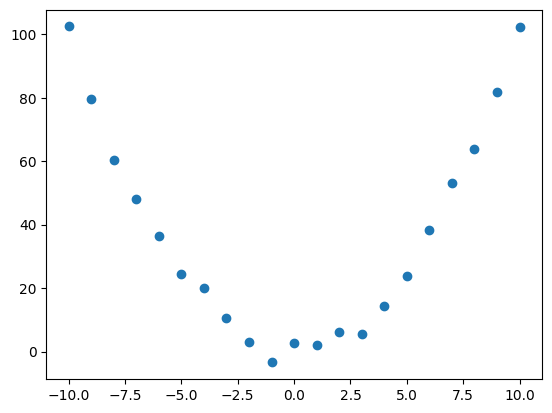

In [70]:
eps = np.random.normal(0, 3, 21)
x = np.asarray(list(range(-10, 11)))
y = x ** 2 + eps

plt.scatter(x, y)

 Linear regression does not work for non linear data

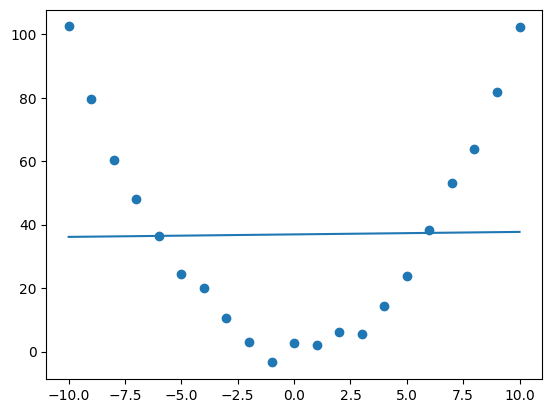

In [71]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x.reshape(-1, 1), y)

a = reg.coef_
b = reg.intercept_

pred = [a * v + b for v in x]
plt.scatter(x, y)
plt.plot(x, pred)

If we know the non linearity we can linearize the relationship
by applying it, the resulting problem becomes linear again

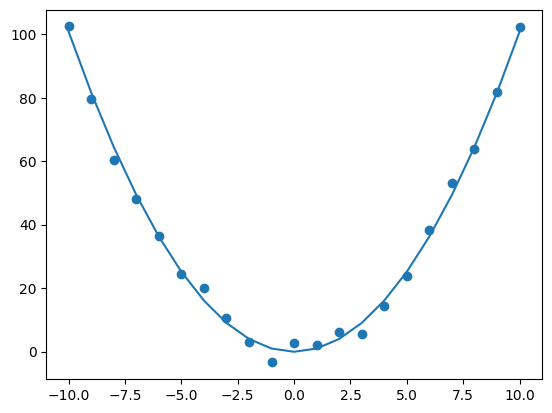

In [72]:
reg = LinearRegression().fit((x ** 2).reshape(-1, 1), y)

a = reg.coef_
b = reg.intercept_

pred = [a * v + b for v in x ** 2]
plt.scatter(x, y)
plt.plot(x, pred)

The problem is: there is an infinity of non linearities and the data can get pretty complex for find non linearity by ourself is not an option. Thankfully Neural Network can approximate any functions and thus learn the non linearity for us.

# Pytorch introduction

## Dataset

In [73]:
from torchvision import datasets
from torchvision import transforms

In [74]:
dataset = datasets.MNIST(
    '../data', 
    train=True, 
    download=True
)
print(len(dataset))

60000


In [75]:
image, label = dataset[0]
print(image.size, label)  # A Black and white image is a 2D matrix (28x28)
image

(28, 28) 5


In [76]:
image, label = dataset[1]
image

In [77]:
image, label = dataset[2]
image

Machine learning is all about creating a function `f` that will learn to approximate a function
For classification we want to approximate a function that will recognize the image it has been given in input

$ f(image) -> class\{ 0-9 \}$

## Linear Regression

## Model definition

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F


n_class = 10


# x                 : N x 28 x 28
# x = Flatten(x)    : N x 728
# x = Linear(x)     : N x 10      = (N x 728) * (728 x 10) + 1 x 10 
# x = Softmax(x)    : N x 10      


linear = nn.Sequential(
    nn.Flatten(),                  # Flatten images from a 2D matrix to 1D => (28x28) => (784,)
    nn.LazyLinear(n_class),        # Simple (a x + b) layer that will learn `a` and `b`
    nn.Softmax(dim=1)              # Normalization so result wil be between [0, 1]
)

## Prepare Images for the model

In [79]:
image, label = dataset[2]
batch = transforms.ToTensor()(image) # Transform an image to a tensor/matrix

print(image)
print(batch.shape)

<PIL.Image.Image image mode=L size=28x28 at 0x7F59571E7E80>
torch.Size([1, 28, 28])


## Make predictions

Of course the model has not been trained yet so the result below are trash.

In [80]:
result = linear(batch)
print('Result:  ', result.shape)

Result:   torch.Size([1, 10])


## Read Predictions

In [81]:
print("\nConfidence of the image to be:")

for v, confidence in enumerate(result.tolist()[0]):
    print(f"  - {v}: {confidence* 100:5.2f}")


prediction = torch.argmax(result)
print('\nPrediction: `', prediction.item(), '` Truth: `', label, '`')


Confidence of the image to be:
  - 0:  9.32
  - 1: 11.79
  - 2: 10.69
  - 3:  8.09
  - 4:  9.25
  - 5: 10.86
  - 6: 13.03
  - 7: 10.33
  - 8:  8.57
  - 9:  8.07

Prediction: ` 6 ` Truth: ` 4 `


# Training

In [82]:
import torch.optim as optim
import torch
import taranis.core.dataset.split as split
from tqdm import tqdm


def newdataloader(batch_size=512):
    # Takes the original dataset and apply transform on the fly
    # Convert image to a tensor
    # normalize the tensor
    normalized_dataset = split.TransformedDatasetClassification(
        dataset, 
        transform=transforms.Compose([                    
            transforms.ToTensor(),                         # Transform the image to tensor
            transforms.Normalize((0.1307,), (0.3081,)),    # Normalize the image
        ])
    )
    
    # Takes care of spliting the dataset into bite size for our model
    dataloader = torch.utils.data.DataLoader(
        normalized_dataset,
        batch_size = batch_size,
        num_workers = 0,
    )
    
    return dataloader


def train(model, epoch=2, lr=0.4):
    dataloader = newdataloader()

    # Gradient optimizer 
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    losses = []
    
    
    with tqdm(total=len(dataloader) * epoch, ncols=100) as progress:

        # Repeat a few times 
        for i in range(epoch):
            total_loss = 0
            count = 0

            # Go through the dataset
            for batch, labels in dataloader:
    
                optimizer.zero_grad()                     # Clear previous derivative

                probabilities = model(batch)              # Make prediction

                loss = F.nll_loss(probabilities, labels)  # Grade the prediction 

                loss.backward()                           # Compute derivative

                optimizer.step()                          # Update parameters using derivative

                total_loss += loss.item()                 # Keep track of loss to make sure it goes down

                count += 1
                
                progress.update(1)
            
            loss = total_loss / count
            losses.append(loss)
            progress.set_description(f"loss: {loss:8.4f}")
    
    return losses

# Train

In [83]:
train(linear, lr=0.4, epoch=2)

loss:  -0.7583: 100%|█████████████████████████████████████████████| 236/236 [00:18<00:00, 12.43it/s]


[-0.6340147324411546, -0.7582738263122106]

## Prediction

In [36]:
image, label = dataset[2]
batch = transforms.ToTensor()(image)

image

In [37]:
result = linear(batch)
print('Result:  ', result.shape)

print("\nConfidence of the image to be:")

for v, confidence in enumerate(result.tolist()[0]):
    print(f"  - {v}: {confidence* 100:5.2f}")


prediction = torch.argmax(result)
print('\nPrediction', prediction.item(), 'Truth:', label)
image

Result:   torch.Size([1, 10])

Confidence of the image to be:
  - 0:  5.93
  - 1:  0.77
  - 2:  7.49
  - 3: 13.11
  - 4: 36.05
  - 5:  6.47
  - 6:  4.61
  - 7:  2.59
  - 8: 10.88
  - 9: 12.11

Prediction 4 Truth: 4


# Non Linearity

Model is linear only so it can only approximate linear relationships
what is we create more layers ?

In [38]:
deepmodel_bad = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(128),    # r1 =  
    nn.LazyLinear(64),     # r2 = (x * a1 + b1) * a2 + b2
    nn.LazyLinear(10),     # r3 = x * w + b
    nn.Softmax(dim=1)      #    w = a1 * a2* a3
                           #    b = b1 * a2* a3 + b2* a3  + b3
)

# r3 = r2 * w3 + b3
# r3 = (r1 * w2 + b2) * w3 + b3
# r3 = r1 * w2 * w3 + b2 * w3  + b3
# r3 = (batch * w1 + b1) * w2 * w3 + b2 * w3  + b3
# r3 = batch * w1 * w2 * w3 + b1 * w2 * w3 + b2 * w3  + b3
#
# r3 = batch * w + b
#  w = w1 * w2 * w3 + b1
#  b =  b1 * w2 * w3 + b2 * w3  + b3
#
#
#   MODEL is still LINEAR
#

batch = transforms.ToTensor()(image)
result = deepmodel_bad(batch)
result.shape

train(deepmodel_bad, lr=1, epoch=2)

loss:  -0.8991: 100%|█████████████████████████████████████████████| 236/236 [00:21<00:00, 10.90it/s]


[-0.7813517896426936, -0.8990562563225374]

## Breaking Linearity

In [39]:
#
# Adding non linear function between 
#
deepmodel = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(128),    # r1 = batch * w1 + b1
    nn.ReLU(),             # r2 = max(r1, 0)
    nn.LazyLinear(64),     # r3 = r3 * w3 + b3
    nn.ReLU(),             # r4 = max(r3, 0)
    nn.LazyLinear(10),     # r5 = r4 * w4 + b4
    nn.Softmax(dim=1)  
)

#
# Layers cannot be factorized anymore
#
batch = transforms.ToTensor()(image)
result = deepmodel(batch)

# How does training work ?
train(deepmodel, lr=2, epoch=2)

loss:  -0.9118: 100%|█████████████████████████████████████████████| 236/236 [00:21<00:00, 10.98it/s]


[-0.7066823081192324, -0.9118398892677436]

# Mesuring network's ability

In [40]:
def test_model(model):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset = datasets.MNIST('../data', train=False,  transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=4096, num_workers=1) 
    
    total = len(dataset)
    
    with torch.no_grad():
        test_loss = 0
        correct = 0
        
        for batch, labels in loader:
            output = model(batch)
            test_loss += F.nll_loss(output, labels, reduction='sum').item()  
            
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(labels.view_as(pred)).sum().item()

        print(f'Accuracy {correct / total * 100:.2f} {100 - correct / total * 100:.2f}')

In [41]:
test_model(linear)
test_model(deepmodel_bad)
test_model(deepmodel)

Accuracy 83.99 16.01
Accuracy 89.31 10.69
Accuracy 89.94 10.06


In [42]:
train(linear       , lr=0.4, epoch=5)
train(deepmodel_bad, lr=1  , epoch=5)
train(deepmodel    , lr=1  , epoch=5)

loss:  -0.9671: 100%|█████████████████████████████████████████████| 590/590 [00:56<00:00, 10.35it/s]


[-0.9434486470990262,
 -0.9525715915833489,
 -0.9588791030948445,
 -0.9634286251108525,
 -0.9671356087013826]

In [43]:
test_model(linear)
test_model(deepmodel_bad)
test_model(deepmodel)

Accuracy 91.96 8.04
Accuracy 91.68 8.32
Accuracy 96.63 3.37


Linear model plateau quickly.
Deeper model can learn more but take longer to train.

# Going faster with GPU

In [44]:
def gpu_train(original_model, epoch=2, lr=0.4, batch_size=2048):
    dataloader = newdataloader(2048)


    device = torch.cuda.current_device()               # HERE Get GPU device
    model = original_model.to(device)                  # HERE Convert model to GPU
    
    optimizer = optim.Adadelta(model.parameters(), lr=1)

    with tqdm(total=len(dataloader) * epoch, ncols=100) as progress:
        for i in range(epoch):
            losses = []
            count = 0
            for batch, labels in dataloader:
                batch, labels = batch.to(device), labels.to(device) # HERE: Convert input to GPU

                optimizer.zero_grad()

                probabilities = model(batch)

                loss = F.nll_loss(probabilities, labels)

                loss.backward()

                optimizer.step()

                losses.append(loss.detach())
                count += 1
                
                progress.update(1)

            total_loss = (sum(losses) / count).item()
            progress.set_description(f"loss: {total_loss:8.4f}")

    
def gpu_test_model(model):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset = datasets.MNIST('../data', train=False,  transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=4096, num_workers=1) 
    total = len(dataset)
    
    device = torch.cuda.device("cuda:0")  # HERE
    model = model.to(device=device)       # HERE
    
    with torch.no_grad():
        test_loss = 0
        correct = 0
        
        for batch, labels in loader:
            batch, labels = batch.to(device), labels.to(device) # HERE
            
            output = model(batch)
            test_loss += F.nll_loss(output, labels, reduction='sum').item()  
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(labels.view_as(pred)).sum().item()

        print('Accuracy', correct / total * 100, 100 - correct / total * 100)

In [45]:
gpu_train(linear       , lr=0.4, epoch=5)
gpu_train(deepmodel_bad, lr=0.4, epoch=5)
gpu_train(deepmodel    , lr=0.4, epoch=5)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
gpu_test_model(linear       )
gpu_test_model(deepmodel_bad)
gpu_test_model(deepmodel    )

# Back to x^2

In [84]:
model = nn.Sequential(
    nn.Linear(1, 2),  
    nn.ReLU(),             
    nn.Linear(2, 1), 
)

list(model.parameters())

[Parameter containing:
 tensor([[-0.7833],
         [ 0.1354]], requires_grad=True),
 Parameter containing:
 tensor([ 0.8246, -0.1829], requires_grad=True),
 Parameter containing:
 tensor([[ 0.2866, -0.2149]], requires_grad=True),
 Parameter containing:
 tensor([0.4846], requires_grad=True)]

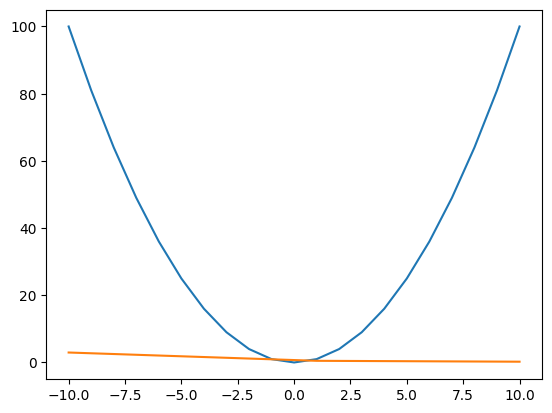

In [85]:
x = np.asarray(list(range(-10, 11)))
y = x ** 2

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
output = torch.tensor(y, dtype=torch.float).unsqueeze(1)
pred = model(input).detach().numpy()

plt.plot(x, y)
plt.plot(x, pred)

In [86]:
def train_reg(model, epoch=100):
    optimizer = optim.Adadelta(model.parameters(), lr=1)

    for i in range(epoch):
        optimizer.zero_grad()
        pred = model(input)
        loss = F.mse_loss(pred, output)
        loss.backward()
        optimizer.step()

        if i % (epoch / 10) == 0:
            print(loss.item())
            
train_reg(model, 2000)

2312.839599609375
1509.873291015625
1238.299072265625
1183.398193359375
1116.421875
1012.7267456054688
966.57568359375
918.90380859375
877.3870239257812
841.6787719726562


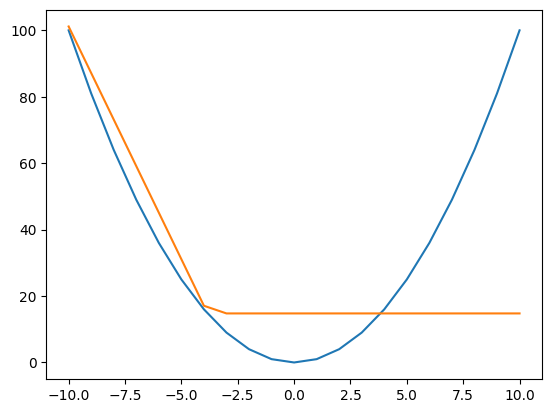

In [87]:
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

# Increase number of neurons

2436.364501953125
72.2223892211914
39.25493240356445
30.27789878845215
23.08865737915039
19.476062774658203
16.36578941345215
13.469139099121094
11.620129585266113
9.753583908081055


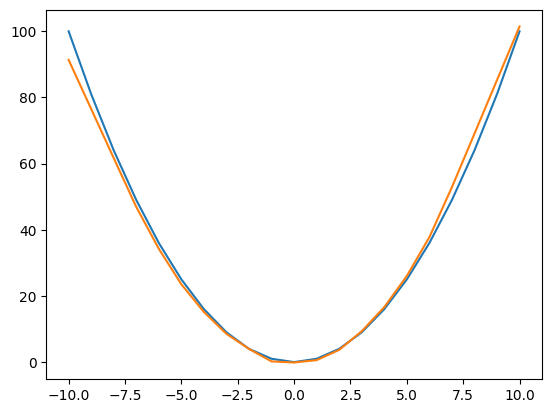

In [88]:
model = nn.Sequential(
    nn.Linear(1, 128),  
    nn.ReLU(),             
    nn.Linear(128, 1), 
)
train_reg(model, 2000)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

# Non Linear correlation

In [89]:
# Regular linear Correlation does not work well shows x, y are essentially not correlated
print(np.corrcoef(x, y))

[[ 1.00000000e+00 -3.07735001e-17]
 [-3.07735001e-17  1.00000000e+00]]


In [90]:
pred = model(input).detach().squeeze().numpy()

#
# Correlation is essentially one
#
print(np.corrcoef(pred, y))

[[1.         0.99608354]
 [0.99608354 1.        ]]


# Generalization

Current models are not able to learn or infer outside of the training set
if we increase the domain of the function from $[-10, 10]$ we can see that the error will keep increasing.

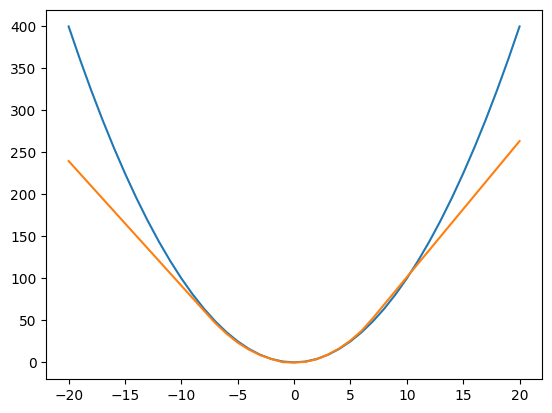

In [91]:
x = np.asarray(list(range(-20, 21)))
y = x ** 2

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

# With sin the issue is more obvious

1.5302960872650146
0.028785156086087227
0.020640904083848
0.015056461095809937
0.011269479990005493
0.008647965267300606
0.0068405079655349255
0.005578835029155016
0.004693575203418732
0.004094248171895742


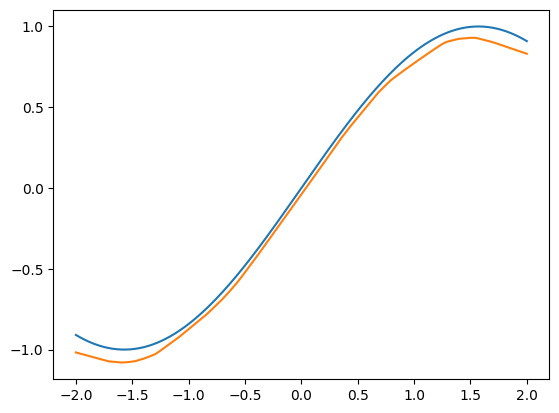

In [92]:
x = np.asarray(list(range(-100, 101))) / 50
y = np.sin(x)

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
output = torch.tensor(y, dtype=torch.float).unsqueeze(1)

model = nn.Sequential(
    nn.Linear(1, 128),  
    nn.ReLU(),             
    nn.Linear(128, 1), 
)

train_reg(model, 2000)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

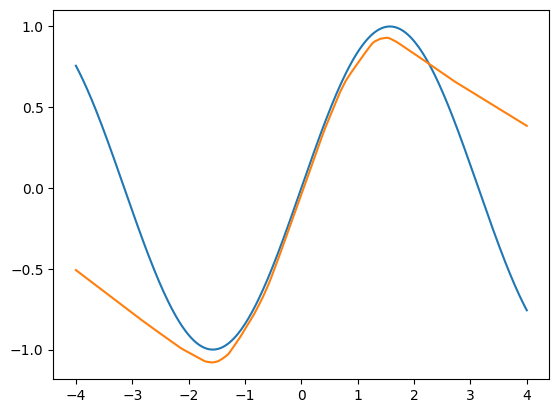

In [93]:
x = np.asarray(list(range(-200, 201))) / 50
y = np.sin(x)

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

0.7597683668136597
0.1417633444070816
0.08461133390665054
0.05500064790248871
0.03959504887461662
0.030751261860132217
0.02601528912782669
0.02396215870976448
0.023704761639237404
0.025010747835040092


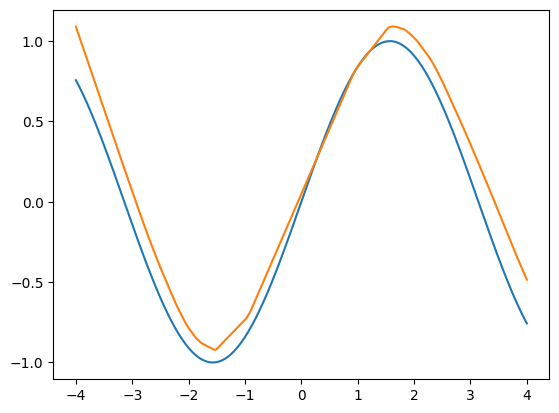

In [94]:
x = np.asarray(list(range(-200, 201))) / 50
y = np.sin(x)

input = torch.tensor(x, dtype=torch.float).unsqueeze(1)
output = torch.tensor(y, dtype=torch.float).unsqueeze(1)

model = nn.Sequential(
    nn.Linear(1, 256),  
    nn.ReLU(),             
    nn.Linear(256, 1), 
)

train_reg(model, 2000)
pred = model(input).detach().numpy()
plt.plot(x, y)
plt.plot(x, pred)

# Different Layers

Linear layers are quite resource intensive often we will use specialized layer for some specific data.
For example, images will often use convolution layers.

Convolution apply a filter on an image and produce another image https://fr.wikipedia.org/wiki/Noyau_(traitement_d%27image)

In [95]:
image, label = dataset[2]
print(image.size, label)  # A Black and white image is a 2D matrix (28x28)
image

(28, 28) 4


In [96]:
conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
print(conv.weight.shape)

batch = transforms.ToTensor()(image)
print(batch.shape)
result = conv(batch)
print(result.shape)

torch.Size([32, 1, 3, 3])
torch.Size([1, 28, 28])
torch.Size([32, 26, 26])


Example of images generated from a convolution

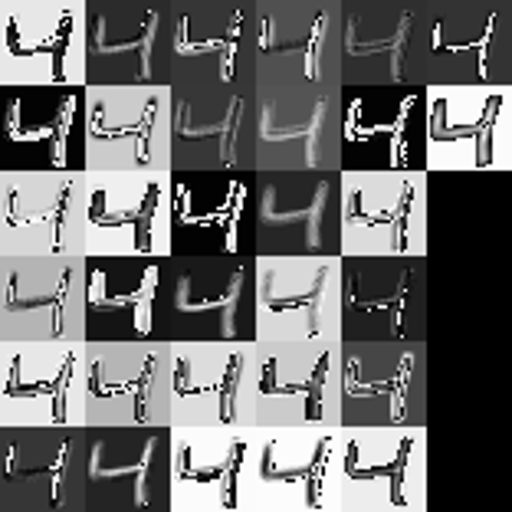

In [97]:
import taranis.core.visualization as viz 
transforms.ToPILImage()(viz.show_conv_layers(result)).resize((512, 512))

# New network with a convolution layer

From a single image it is going to learn to generate 32 new ones to better classify them

In [98]:
576 * 64

36864

In [99]:
from torch.nn import init
from torch import Tensor
import math

import taranis.core.nn as ext_nn
        
conv_model = nn.Sequential(
    # ext_nn.MaskLayer((28, 28)),
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, 1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(576 * 64, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=1),
)

batch = transforms.ToTensor()(image).unsqueeze(0)
batch = torch.concat([batch, batch])
conv_model(batch).shape

torch.Size([2, 1, 28, 28])


torch.Size([2, 10])

## Training

In [100]:
train(conv_model)

loss:  -0.9167: 100%|█████████████████████████████████████████████| 236/236 [02:04<00:00,  1.89it/s]


[-0.7601513155436112, -0.916709793826281]

In [140]:
gpu_train(conv_model, batch_size=1024)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

## Compare

In [101]:
test_model(linear)
test_model(deepmodel_bad)
test_model(deepmodel)
test_model(conv_model.cpu())

Accuracy 82.45 17.55
Accuracy 91.68 8.32
Accuracy 96.63 3.37
Accuracy 91.46 8.54


In [102]:
train(conv_model    , lr=1  , epoch=5)
# gpu_train(conv_model, batch_size=1024, lr=1  , epoch=5)

loss:  -0.9842: 100%|█████████████████████████████████████████████| 590/590 [05:49<00:00,  1.69it/s]


[-0.9239225195626081,
 -0.9653405961343797,
 -0.9762584885298196,
 -0.9808551512532315,
 -0.9841668383549835]

In [103]:
test_model(conv_model.cpu())

Accuracy 98.30 1.70


## Inspect learned Convolution Kernels

torch.Size([32, 26, 26])


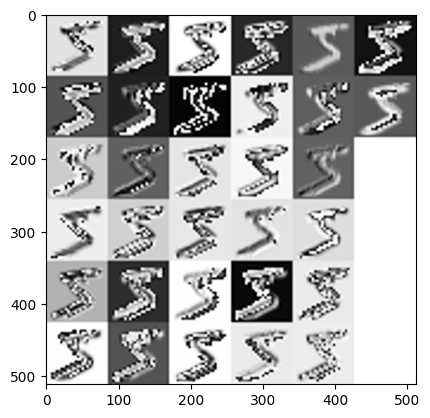

torch.Size([32, 26, 26])


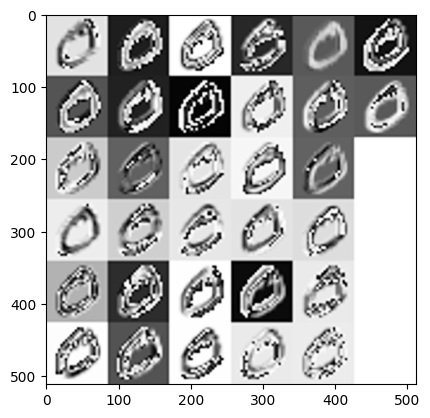

torch.Size([32, 26, 26])


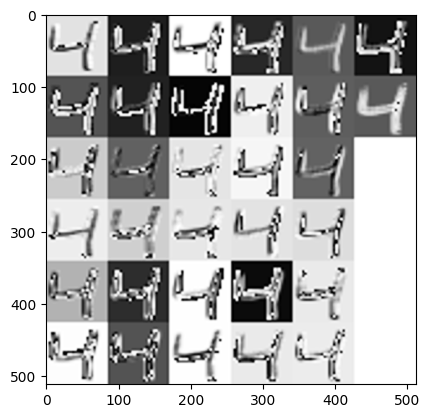

torch.Size([32, 26, 26])


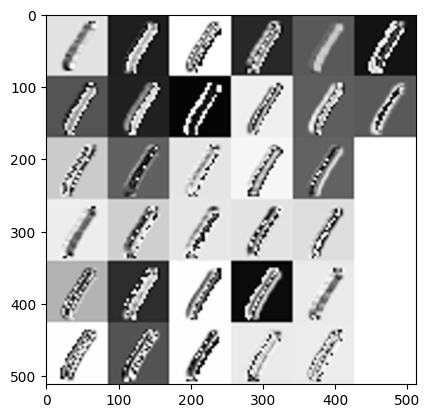

In [105]:
conv_model = conv_model.cpu()

for i in range(4):
    image, label = dataset[i]
    conv = list(conv_model.children())[0]

    batch = transforms.ToTensor()(image)
    result = conv(batch)
    print(result.shape)
    plt.imshow(transforms.ToPILImage()(viz.show_conv_layers(result)).resize((512, 512)), cmap='Greys')
    plt.show()

None torch.Size([1, 1, 28, 28])


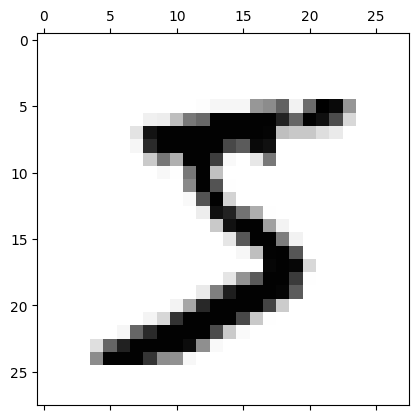

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


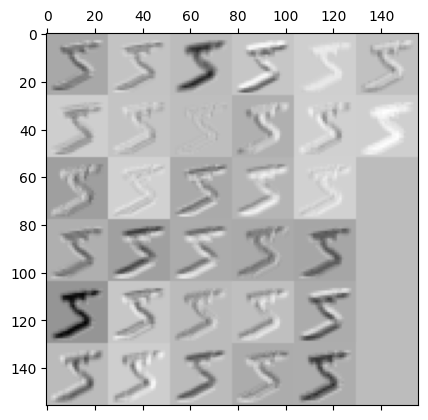

ReLU() torch.Size([1, 32, 26, 26])


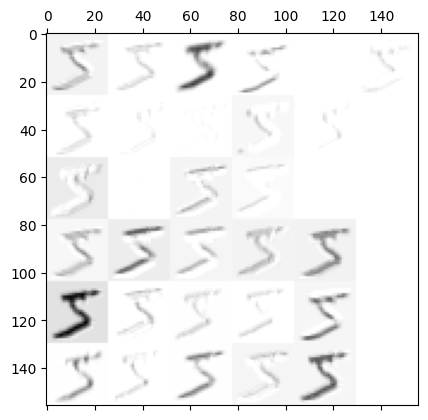

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


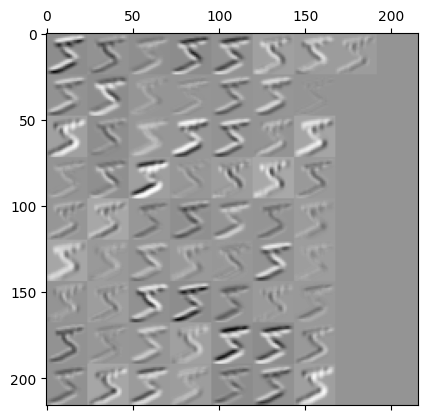

ReLU() torch.Size([1, 64, 24, 24])


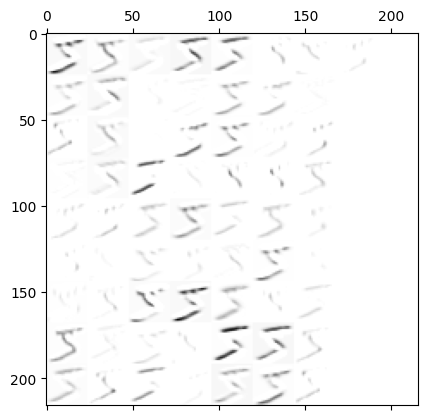

Skip flatten
Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


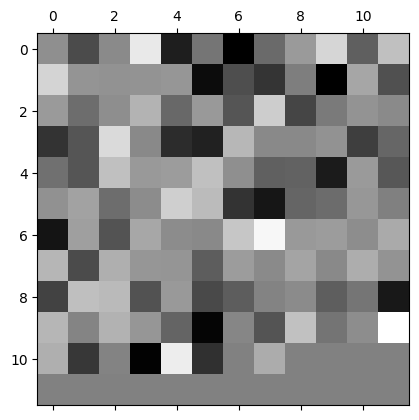

ReLU() torch.Size([1, 128])


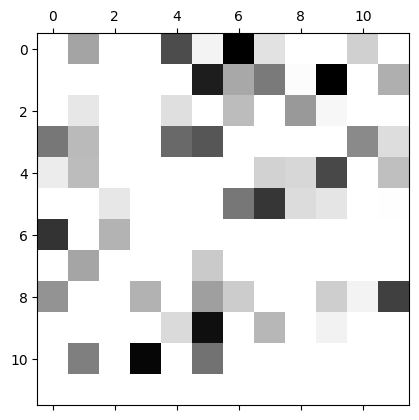

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


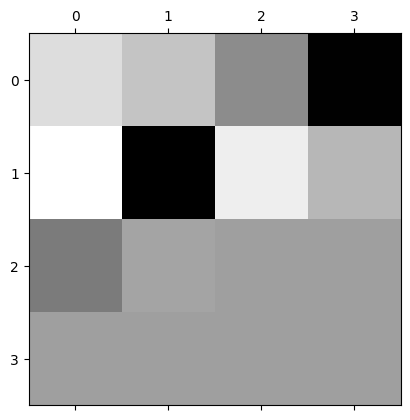

Softmax(dim=1) torch.Size([1, 10])


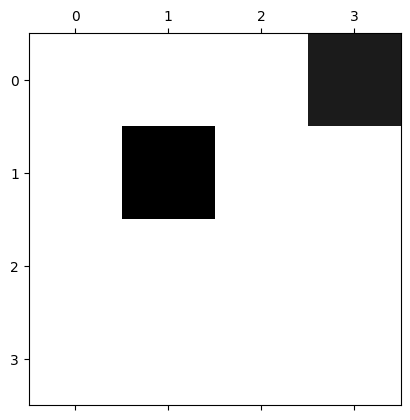

None torch.Size([1, 1, 28, 28])


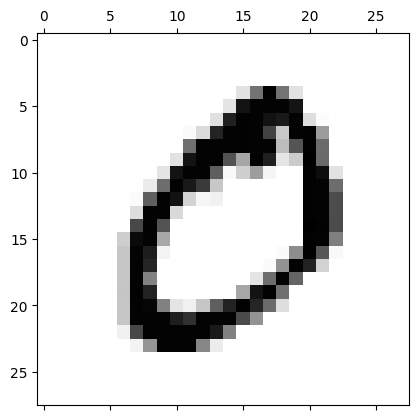

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


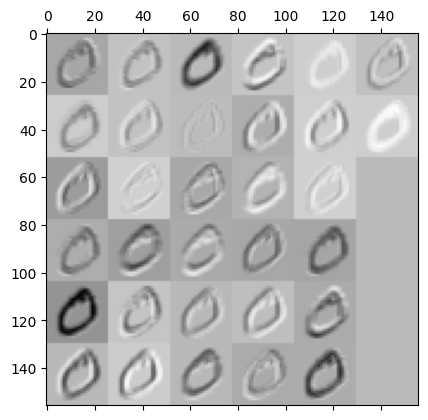

ReLU() torch.Size([1, 32, 26, 26])


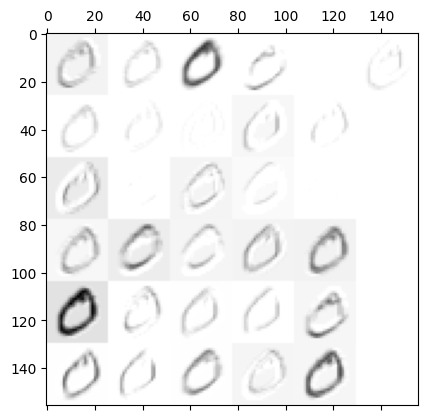

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


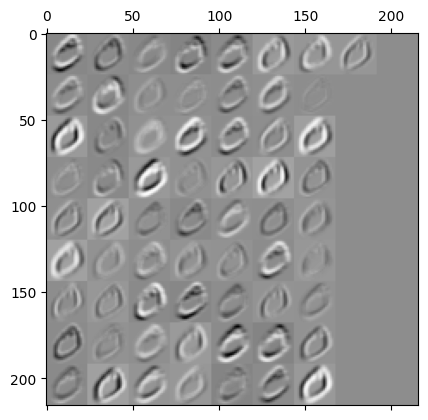

ReLU() torch.Size([1, 64, 24, 24])


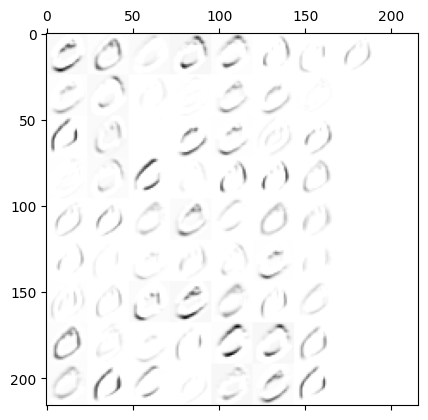

Skip flatten
Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


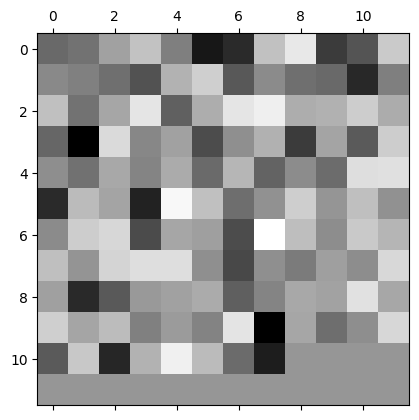

ReLU() torch.Size([1, 128])


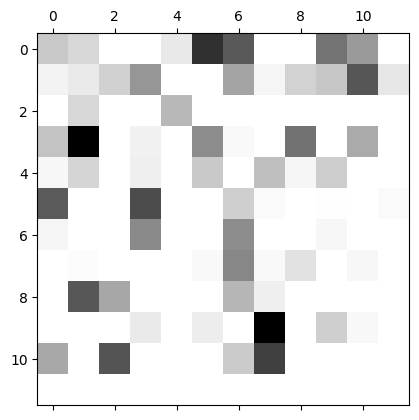

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


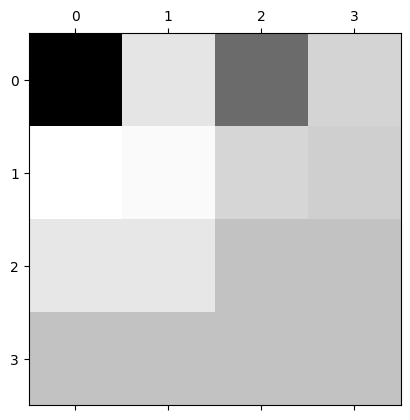

Softmax(dim=1) torch.Size([1, 10])


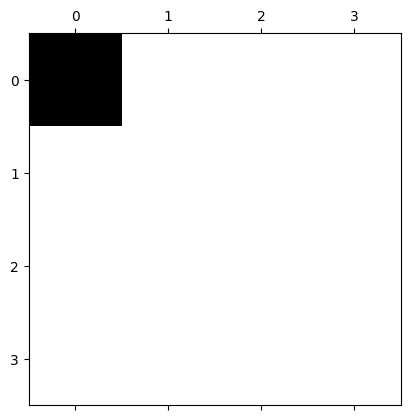

None torch.Size([1, 1, 28, 28])


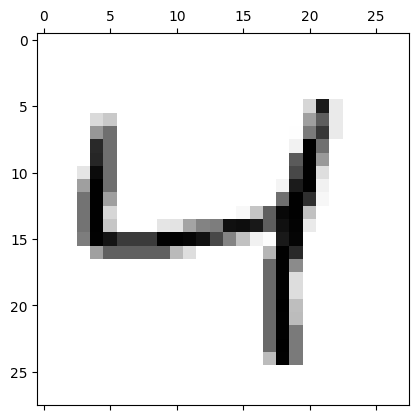

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


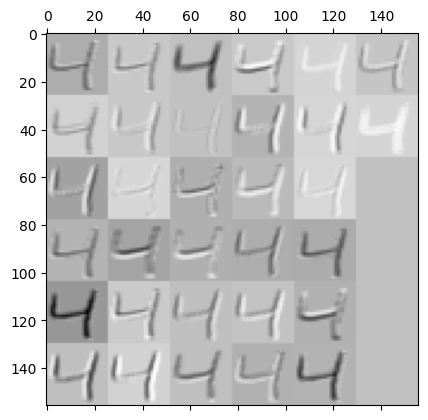

ReLU() torch.Size([1, 32, 26, 26])


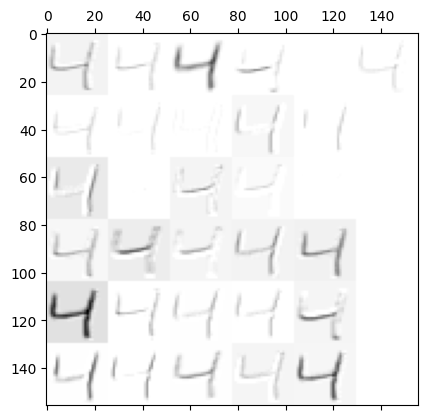

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


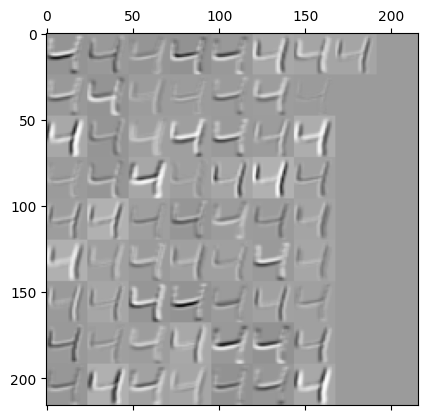

ReLU() torch.Size([1, 64, 24, 24])


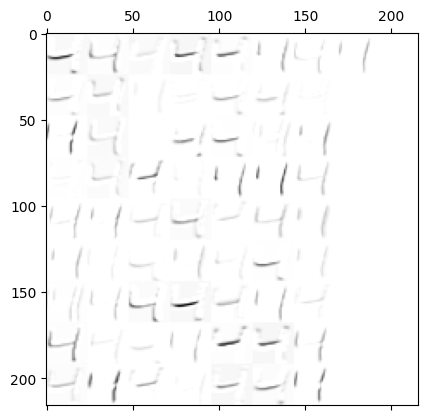

Skip flatten
Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


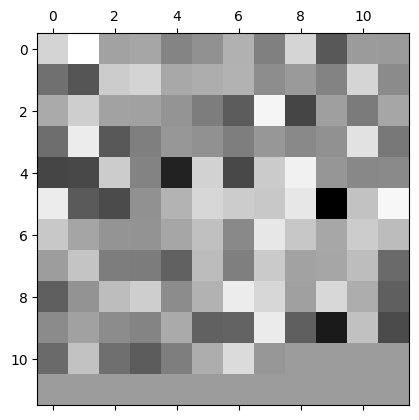

ReLU() torch.Size([1, 128])


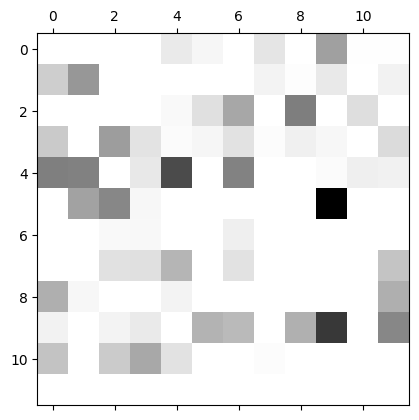

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


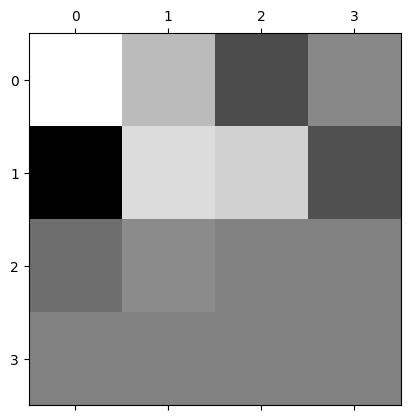

Softmax(dim=1) torch.Size([1, 10])


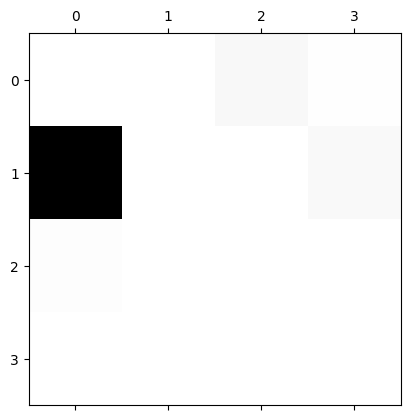

None torch.Size([1, 1, 28, 28])


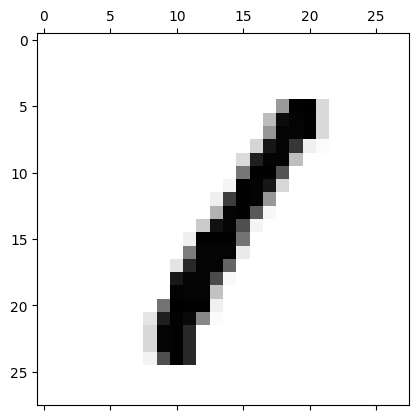

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


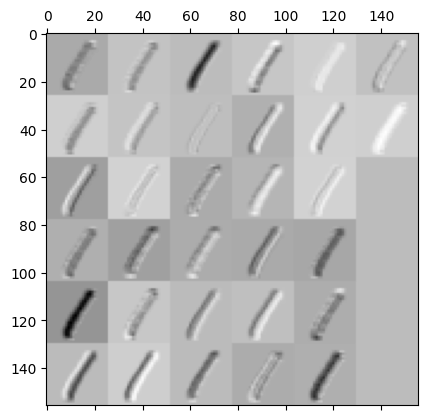

ReLU() torch.Size([1, 32, 26, 26])


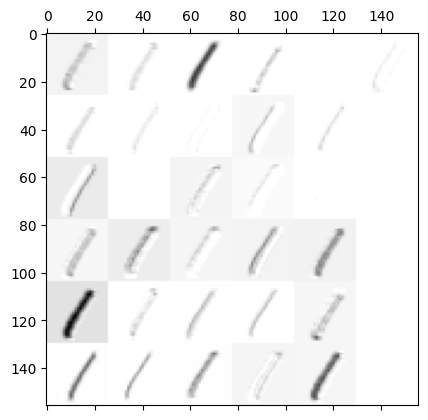

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


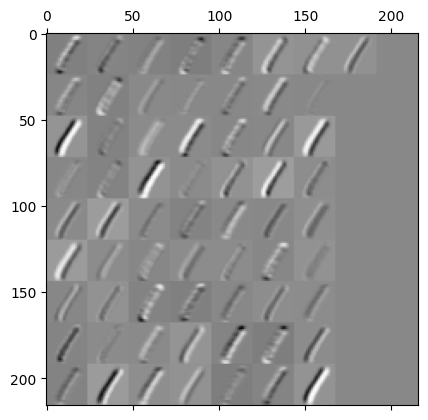

ReLU() torch.Size([1, 64, 24, 24])


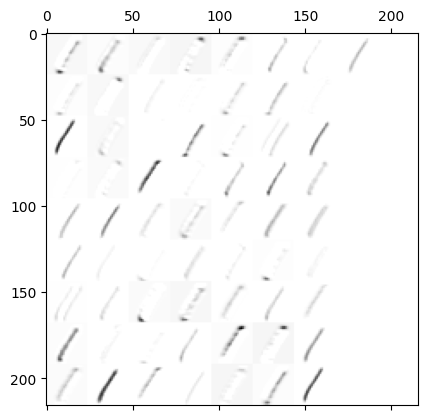

Skip flatten
Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


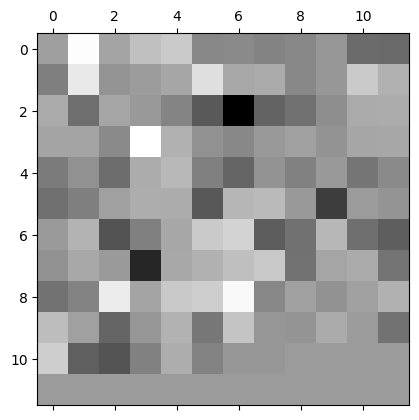

ReLU() torch.Size([1, 128])


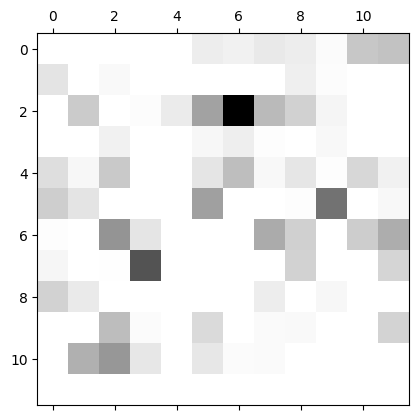

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


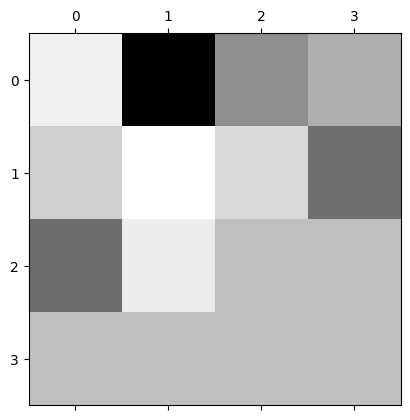

Softmax(dim=1) torch.Size([1, 10])


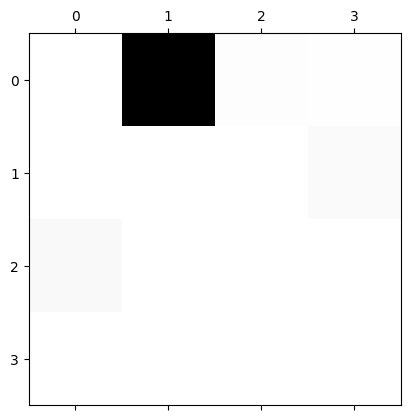

None torch.Size([1, 1, 28, 28])


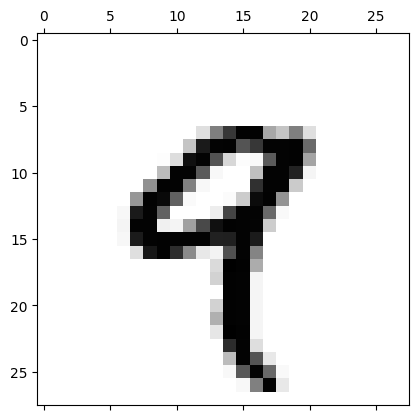

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 32, 26, 26])


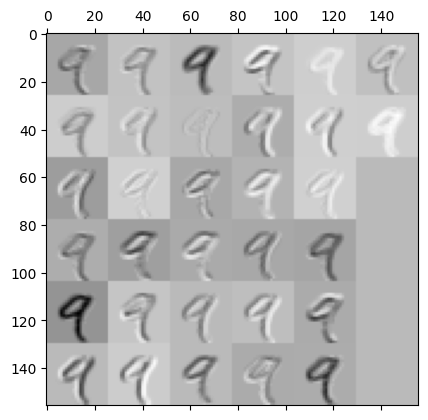

ReLU() torch.Size([1, 32, 26, 26])


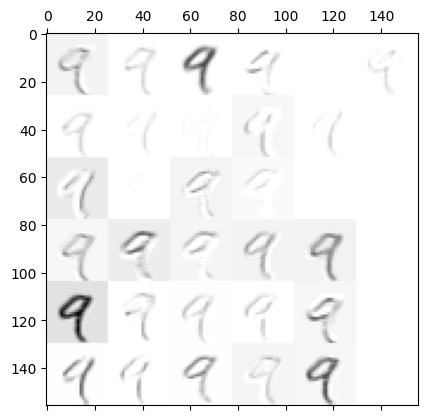

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) torch.Size([1, 64, 24, 24])


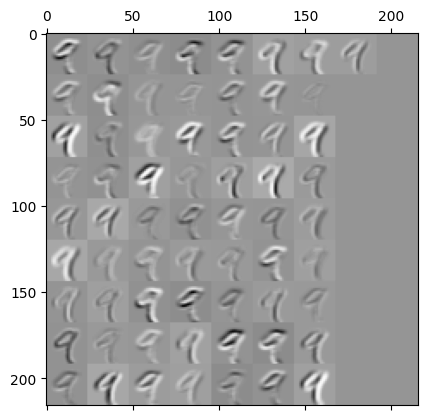

ReLU() torch.Size([1, 64, 24, 24])


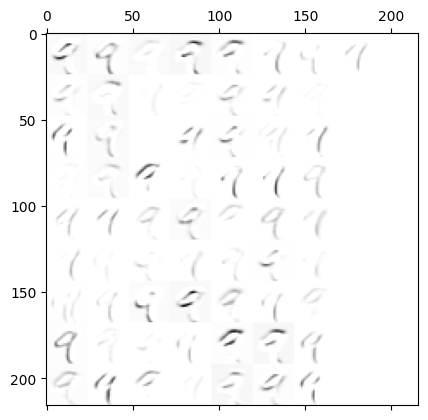

Skip flatten
Linear(in_features=36864, out_features=128, bias=True) torch.Size([1, 128])


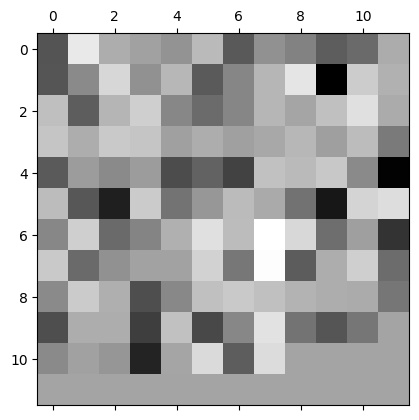

ReLU() torch.Size([1, 128])


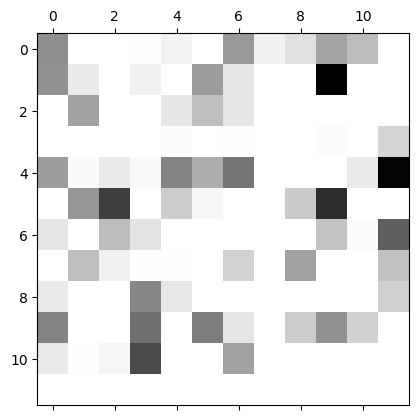

Linear(in_features=128, out_features=10, bias=True) torch.Size([1, 10])


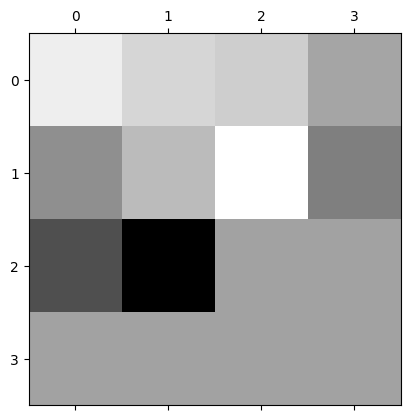

Softmax(dim=1) torch.Size([1, 10])


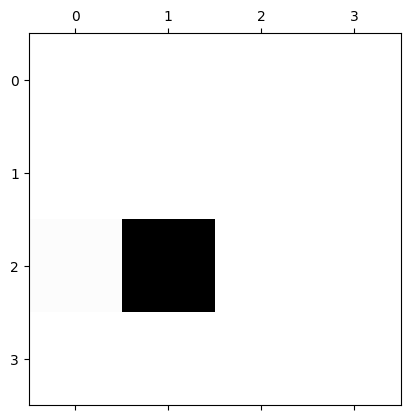

In [111]:
importlib.reload(viz)
viz.show_steps(conv_model, dataset)

In [112]:
list(conv_model.children())[0].weight.abs().mean()

tensor(0.2035, grad_fn=<MeanBackward0>)